In [1]:
from credit_card_data import generate_raw_data_with_income, generate_win_data_with_income
from sklearn.linear_model import LogisticRegression
from functools import reduce
import numpy as np
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import pickle

In [42]:
"""
T = 60
N = 300
m_Z, m_Y, _, _ = generate_raw_data_with_income(T, N)
win_size = 24
train_data, train_label, test_data, test_label = generate_win_data_with_income(m_Z, m_Y, win_size)

train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)
"""

In [43]:
"""
len(train_label)
"""

8640

In [44]:
"""
train_label_binary = [1 if i == 2 else 0 for i in train_label]
test_label_binary = [1 if i == 2 else 0 for i in test_label]
"""

In [45]:
"""
filename = './train_data'
fileObject = open(filename, 'wb')
pickle.dump(train_data, fileObject)
fileObject.close()
"""

In [46]:
"""
filename = './train_label'
fileObject = open(filename, 'wb')
pickle.dump(train_label_binary, fileObject)
fileObject.close()
"""

In [47]:
"""
filename = './test_data'
fileObject = open(filename, 'wb')
pickle.dump(test_data, fileObject)
fileObject.close()
"""

In [48]:
"""
filename = './test_label'
fileObject = open(filename, 'wb')
pickle.dump(test_label_binary, fileObject)
fileObject.close()
"""

In [51]:
load_1 = open('train_data','rb')
load_2 = open('train_label','rb')
load_3 = open('test_data','rb')
load_4 = open('test_label','rb')
train_data = np.array(pickle.load(load_1))
train_label = np.array(pickle.load(load_2))
test_data = np.array(pickle.load(load_3))
test_label = np.array(pickle.load(load_4))

In [52]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(8640, 24) (8640,) (2160, 24) (2160,)


In [71]:
load_1 = open('train_data_HMM','rb')
load_2 = open('train_label_HMM','rb')
load_3 = open('test_data_HMM','rb')
load_4 = open('test_label_HMM','rb')
train_data_HMM = np.array(pickle.load(load_1))
train_label_HMM = np.array(pickle.load(load_2))
test_data_HMM = np.array(pickle.load(load_3))
test_label_HMM = np.array(pickle.load(load_4))

In [72]:
print(train_data_HMM.shape, train_label_HMM.shape, test_data_HMM.shape, test_label_HMM.shape)

(7862, 30) (7862,) (2041, 30) (2041,)


## Upper Bound

In [53]:
def encode(z):
    res = 0
    for i in z:
        res *= 2
        res += i
    return res

data = {}
for i in range(len(test_label)):
    x = encode(test_data[i])
    if x in data:
        data[x]['count'] += 1
        data[x]['label'] += test_label[i]
    else:
        data[x] = {'count': 1, 'label': test_label[i]}

y_pred = []
for z in test_data:
    x = encode(z)
    if x in data:
        y_pred.append(data[x]['label'] / data[x]['count'])
    else:
        y_pred.append(0)
y_pred = np.array(y_pred)

In [73]:
def encode(z):
    res = 0
    for i in z:
        res *= 2
        res += i
    return res

data_HMM = {}
for i in range(len(test_label_HMM)):
    x = encode(test_data_HMM[i])
    if x in data_HMM:
        data_HMM[x]['count'] += 1
        data_HMM[x]['label'] += test_label_HMM[i]
    else:
        data_HMM[x] = {'count': 1, 'label': test_label_HMM[i]}

y_pred_HMM = []
for z in test_data_HMM:
    x = encode(z)
    if x in data_HMM:
        y_pred_HMM.append(data_HMM[x]['label'] / data_HMM[x]['count'])
    else:
        y_pred_HMM.append(0)
y_pred_HMM = np.array(y_pred_HMM)

In [54]:
def criteria(pred, label, threshold):
    recall = []
    precision = []
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    TP += ((pred > threshold).flatten()&(label == 1)).sum()
    TN += ((pred < threshold).flatten()&(label == 0)).sum()
    FP += ((pred > threshold).flatten()&(label == 0)).sum()
    FN += ((pred < threshold).flatten()&(label == 1)).sum()
    return TP, TN, FP, FN

def plot(pred, label, func):
    xs = []
    ys = []
    steps = 1000
    l, r = pred.min(), pred.max()
    for i in range(steps):
        t = l + (r - l) * i / steps
        x, y = func(pred, label, t)
        xs.append(x)
        ys.append(y)
    return xs, ys

In [55]:
def precision_recall(pred, label, threshold):
    TP, TN, FP, FN = criteria(pred, label, threshold)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return recall, precision

def precision_recall_plot(pred, label):
    return plot(pred, label, precision_recall)

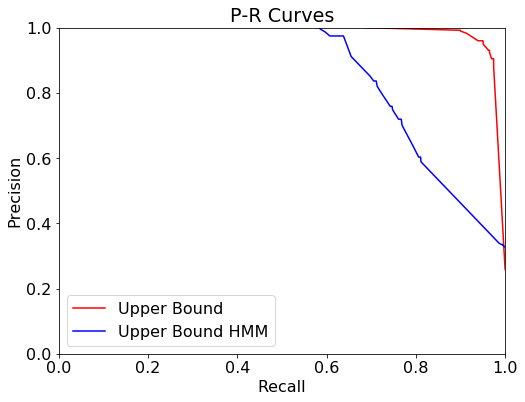

In [95]:
upper_recall, upper_precision = precision_recall_plot(y_pred, test_label)
upper_recall_HMM, upper_precision_HMM = precision_recall_plot(y_pred_HMM, test_label_HMM)


plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(upper_recall, upper_precision, label='Upper Bound', color = 'red')
plt.plot(upper_recall_HMM, upper_precision_HMM, label='Upper Bound HMM', color = 'blue')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.show()

## Naive Bayes

In [59]:
gnb = GaussianNB()
gnb_pred = gnb.fit(train_data, train_label).predict(test_data)
gnb_predictions = gnb.predict(test_data)
gnb_probs = gnb.predict_proba(test_data)[:, 1]

In [75]:
gnb_HMM = GaussianNB()
gnb_pred_HMM = gnb_HMM.fit(train_data_HMM, train_label_HMM).predict(test_data_HMM)
gnb_predictions_HMM = gnb_HMM.predict(test_data_HMM)
gnb_probs_HMM = gnb_HMM.predict_proba(test_data_HMM)[:, 1]

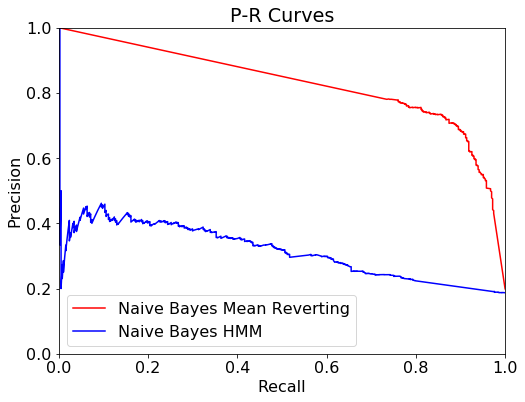

In [97]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

gnb_precision, gnb_recall, gnb_thresholds = precision_recall_curve(test_label, gnb_probs)
gnb_precision_HMM, gnb_recall_HMM, gnb_thresholds_HMM = precision_recall_curve(test_label_HMM, gnb_probs_HMM)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(gnb_recall, gnb_precision, 'r', label='Naive Bayes Mean Reverting')
plt.plot(gnb_recall_HMM, gnb_precision_HMM, 'b', label='Naive Bayes HMM', color = 'blue')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.savefig('NB.jpg')
plt.show()

## Logistic Regression

In [61]:
lr = LogisticRegression(class_weight="balanced", penalty='l2', solver = 'sag')
lr.fit(train_data, train_label)
lr_predictions = lr.predict(test_data)
lr_probs = lr.predict_proba(test_data)[:, 1]

In [77]:
lr_HMM = LogisticRegression(class_weight="balanced", penalty='l2', solver = 'sag')
lr_HMM.fit(train_data_HMM, train_label_HMM)
lr_predictions_HMM = lr_HMM.predict(test_data_HMM)
lr_probs_HMM = lr_HMM.predict_proba(test_data_HMM)[:, 1]

<Figure size 432x288 with 0 Axes>

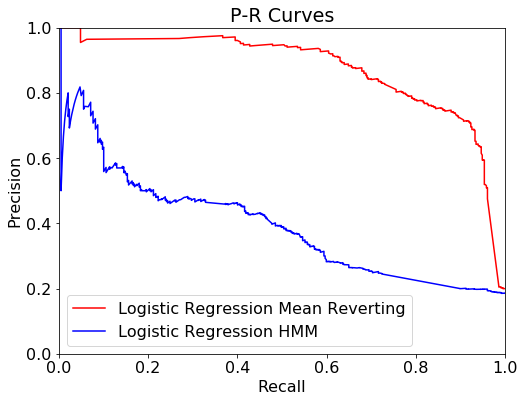

In [99]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(test_label, lr_probs)
lr_precision_HMM, lr_recall_HMM, lr_thresholds_HMM = precision_recall_curve(test_label_HMM, lr_probs_HMM)

plt.clf()
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(lr_recall, lr_precision, label='Logistic Regression Mean Reverting', color = 'red')
plt.plot(lr_recall_HMM, lr_precision_HMM, label='Logistic Regression HMM', color = 'blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.savefig('LR.jpg')
plt.show()

## SVM

In [63]:
from sklearn.svm import SVC
from sklearn import svm

In [64]:
svm_model = SVC(gamma='auto', class_weight='balanced', kernel='rbf', max_iter= -1, degree=3, probability=True)
svm_model.fit(train_data, train_label) 

svm_predictions = svm_model.predict(test_data)
svm_probs = svm_model.predict_proba(test_data)[:, 1]

In [90]:
svm_model_HMM = SVC(kernel = 'rbf', gamma = 'auto', C = 0.1, class_weight='balanced', probability=True)
svm_model_HMM.fit(train_data_HMM, train_label_HMM)

svm_predictions_HMM = svm_model_HMM.predict(test_data_HMM)
svm_probs_HMM = svm_model_HMM.predict_proba(test_data_HMM)[:, 1]

<Figure size 432x288 with 0 Axes>

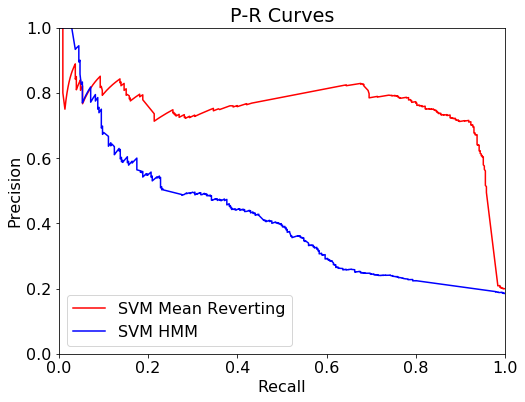

In [100]:
## P-R Curve for SVM Algorithm 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
svm_precision, svm_recall, svm_thresholds = precision_recall_curve(test_label, svm_probs)
svm_precision_HMM, svm_recall_HMM, svm_thresholds_HMM = precision_recall_curve(test_label_HMM, svm_probs_HMM)

plt.clf()
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(svm_recall, svm_precision, label='SVM Mean Reverting', color = 'red')
plt.plot(svm_recall_HMM, svm_precision_HMM, label='SVM HMM', color = 'blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.savefig('SVM.jpg')
plt.show()

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

best_model = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2,  n_estimators = 20, class_weight = 'balanced')
best_model.fit(train_data, train_label)

rf_predictions = best_model.predict(test_data)
rf_probs = best_model.predict_proba(test_data)[:, 1]

In [81]:
from sklearn.ensemble import RandomForestClassifier

best_model_HMM = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2,  n_estimators = 20, class_weight = 'balanced')
best_model_HMM.fit(train_data_HMM, train_label_HMM)

rf_predictions_HMM = best_model_HMM.predict(test_data_HMM)
rf_probs_HMM = best_model_HMM.predict_proba(test_data_HMM)[:, 1]

<Figure size 432x288 with 0 Axes>

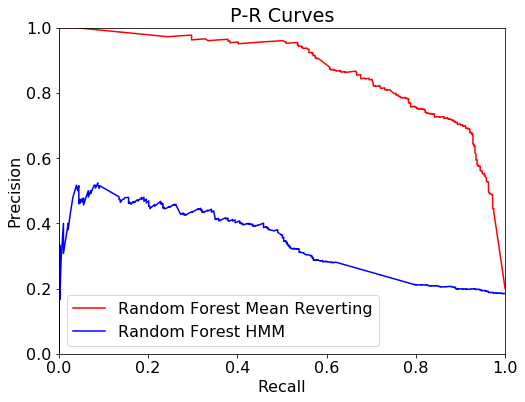

In [101]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

rf_precision, rf_recall, rf_thresholds = precision_recall_curve(test_label, rf_probs)
rf_precision_HMM, rf_recall_HMM, rf_thresholds_HMM = precision_recall_curve(test_label_HMM, rf_probs_HMM)

plt.clf()
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(rf_recall, rf_precision, label='Random Forest Mean Reverting', color = 'red')
plt.plot(rf_recall_HMM, rf_precision_HMM, label='Random Forest HMM', color = 'blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.savefig('RF.jpg')
plt.show()

## Xgboost

In [68]:
from xgboost import XGBClassifier

best_model = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.05,max_depth=2,min_child_weight=1,
                          scale_pos_weight=list(train_label).count(0) / list(train_label).count(1))
best_model.fit(train_data, train_label)

xgb_predictions = best_model.predict(test_data)
xgb_probs = best_model.predict_proba(test_data)[:, 1]

In [84]:
from xgboost import XGBClassifier

best_model_HMM = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.05,max_depth=2,min_child_weight=1,
                          scale_pos_weight=list(train_label_HMM).count(0) / list(train_label_HMM).count(1))
best_model_HMM.fit(train_data_HMM, train_label_HMM)

xgb_predictions_HMM = best_model_HMM.predict(test_data_HMM)
xgb_probs_HMM = best_model_HMM.predict_proba(test_data_HMM)[:, 1]

<Figure size 432x288 with 0 Axes>

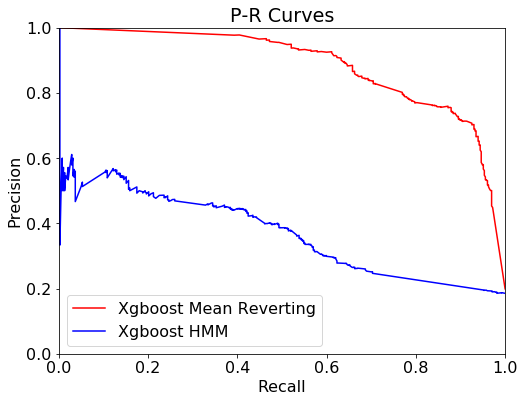

In [102]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(test_label, xgb_probs)
xgb_precision_HMM, xgb_recall_HMM, xgb_thresholds_HMM = precision_recall_curve(test_label_HMM, xgb_probs_HMM)

plt.clf()
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(xgb_recall, xgb_precision, label='Xgboost Mean Reverting', color = 'red')
plt.plot(xgb_recall_HMM, xgb_precision_HMM, label='Xgboost HMM', color = 'blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('P-R Curves')
plt.legend(loc="lower left")
plt.savefig('XG.jpg')
plt.show()

## All

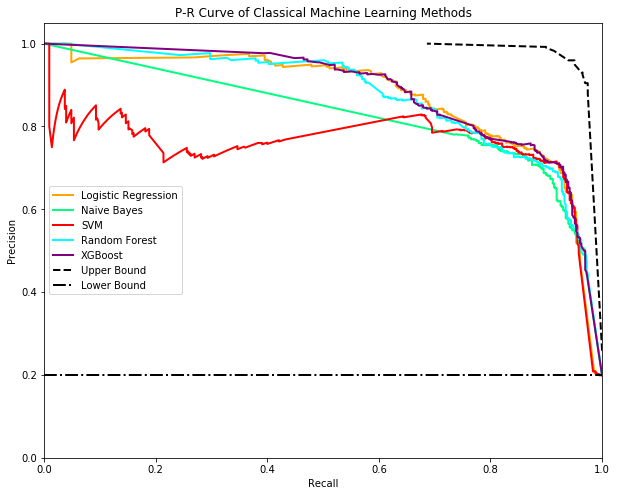

In [70]:
plt.figure(figsize = (10,8))
plt.clf()
plt.plot(lr_recall, lr_precision, label='Logistic Regression', linewidth=2, color = 'orange')
plt.plot(gnb_recall, gnb_precision, label='Naive Bayes', linewidth=2, color = 'springgreen')
plt.plot(svm_recall, svm_precision, label='SVM', linewidth=2, color = 'red')
plt.plot(rf_recall, rf_precision, label='Random Forest', linewidth=2, color = 'cyan')
plt.plot(xgb_recall, xgb_precision, label='XGBoost', linewidth=2, color = 'purple')
plt.plot(upper_recall, upper_precision, label='Upper Bound', linewidth=2, linestyle='--', color = 'black')
#plt.plot([upper_recall[678]], [upper_precision[678]], marker='o', markersize=3, color="red")
plt.axhline(y=list(test_label).count(1) / len(test_label), label='Lower Bound', linestyle='dashdot', 
            linewidth=2, color = 'black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve of Classical Machine Learning Methods')
plt.legend(prop = {'size': 10})
plt.savefig('classic ML.jpg')
plt.show()

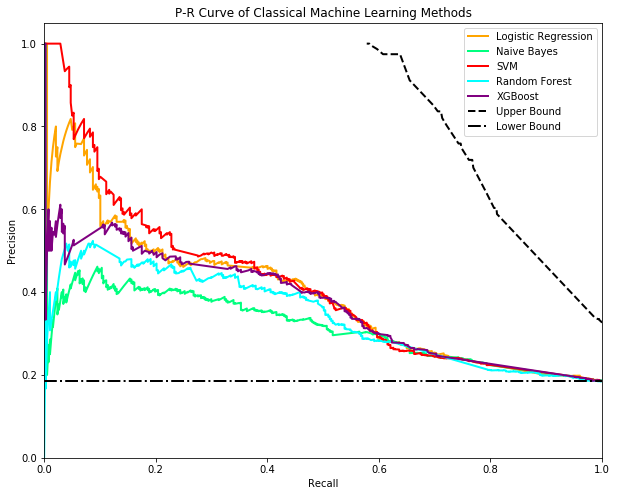

In [92]:
plt.figure(figsize = (10,8))
plt.clf()
plt.plot(lr_recall_HMM, lr_precision_HMM, label='Logistic Regression', linewidth=2, color = 'orange')
plt.plot(gnb_recall_HMM, gnb_precision_HMM, label='Naive Bayes', linewidth=2, color = 'springgreen')
plt.plot(svm_recall_HMM, svm_precision_HMM, label='SVM', linewidth=2, color = 'red')
plt.plot(rf_recall_HMM, rf_precision_HMM, label='Random Forest', linewidth=2, color = 'cyan')
plt.plot(xgb_recall_HMM, xgb_precision_HMM, label='XGBoost', linewidth=2, color = 'purple')
plt.plot(upper_recall_HMM, upper_precision_HMM, label='Upper Bound', linewidth=2, linestyle='--', color = 'black')
#plt.plot([upper_recall[678]], [upper_precision[678]], marker='o', markersize=3, color="red")
plt.axhline(y=list(test_label_HMM).count(1) / len(test_label_HMM), label='Lower Bound', linestyle='dashdot', 
            linewidth=2, color = 'black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve of Classical Machine Learning Methods')
plt.legend(prop = {'size': 10})
plt.show()